In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.manifold import TSNE

In [2]:
import os

audio_folder = '/home/badr/explore_wav2vec/spoken_digit/speech_data'
audio_files = []

for file in os.listdir(audio_folder):
    if file.endswith('.wav') or file.endswith('.mp3'):
        audio_files.append(os.path.join(audio_folder, file))



In [3]:
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [4]:
import librosa

audio_data = {}
metadata = {}

for file in audio_files:
    file_name = os.path.basename(file)
    label, speaker_id, sample_number = file_name.split('_')
    
    # Read audio file
    audio, sr = librosa.load(file, sr=8000)
    
    # Store audio data
    audio_data[file_name] = audio
    
    # Store metadata
    metadata[file_name] = {
        'label': label,
        'speaker_id': speaker_id,
        'sample_number': sample_number.split('.')[0]
    }


In [5]:
metadata[audio_files[0].split('/')[-1]]

{'label': '4', 'speaker_id': 'nicolas', 'sample_number': '28'}

In [14]:
resampled_samples = defaultdict()

for i, sample_ID in enumerate(metadata):


    # Get audio data
    file_name = audio_folder + '/' + sample_ID

    waveform, sample_rate = torchaudio.load(file_name)
    
    resampler = torchaudio.transforms.Resample(8_000, 16_000) 

    waveform = resampler(waveform)

    resampled_samples[sample_ID] = waveform

    print(f"{(100*i)/len(audio_files):.2f}%", end='\r')

In [7]:
# Load pre-trained model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")


/home/badr/anaconda3/lib/python3.11/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [338]:
def get_layer_representations(speech_samples, model):
    """
    Get layer representations for speech samples using a given model.

    Parameters:
    - speech_samples (dict): A dictionary containing speech samples.
    - model: The model used for obtaining layer representations.

    Returns:
    - layer_reprs (defaultdict): A dictionary containing layer representations for each speech sample.
    """
    layer_reprs = defaultdict()

    for i, sample_ID in enumerate(speech_samples):

        # Tokenize and forward pass through the model
        processed_sample = processor(
            speech_samples[sample_ID].squeeze().numpy(), 
            return_tensors="pt", 
            sampling_rate=16000
        ).input_values

        with torch.no_grad():
            layer_reprs[sample_ID] = model(processed_sample, output_hidden_states=True).hidden_states

        print(f"{(100*i)/len(speech_samples):.2f}% completed!", end='\r')

    return layer_reprs

# for i, sample_ID in enumerate(resampled_samples):
    
#     # Tokenize and forward pass through the model
#     processed_sample = processor(
#         resampled_samples[sample_ID].squeeze().numpy(), 
#         return_tensors="pt", 
#         sampling_rate=16000
#     ).input_values

#     with torch.no_grad():
#         layer_reprs[sample_ID] = model(processed_sample, output_hidden_states=True).hidden_states


#     print(f"{(100*i)/len(resampled_samples):.2f}%", end='\r')

In [360]:
layer_reprs_pt_large['7_george_0.wav'][16].mean(dim=1).shape

torch.Size([1, 1024])

In [142]:
# Get metadata in lists 
# Iterate over the layers and plot the representations
speaker_ids, labels = [], []

for sample_ID in layer_reprs:
    speaker_id = metadata[sample_ID]['speaker_id']
    label = int(metadata[sample_ID]['label'])

    speaker_ids.append(speaker_id)
    labels.append(label)

In [359]:
len(layer_reprs_pt_large[list(layer_reprs_pt_large.keys())[0]])

25

In [361]:
def calculate_tsne_layer_representations(layer_reprs):
    """
    Calculates T-SNE layer representations for each layer in the given layer representations.

    Args:
        layer_reprs (dict): A dictionary containing layer representations for each sample ID.

    Returns:
        list: A list of T-SNE layer representations for each layer.
    """
    tsne_layer_representations = []

    num_layers = len(layer_reprs[list(layer_reprs.keys())[0]])

    for layer_index in range(1, num_layers):
        # Extract representations from the specified layer
        layer_representations = []

        for sample_ID in layer_reprs:
            layer_representations.append(layer_reprs[sample_ID][layer_index].mean(dim=1).squeeze().numpy())

        # Convert the representations to a NumPy array
        layer_representations = np.array(layer_representations)

        # Perform T-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        tsne_representation = tsne.fit_transform(layer_representations)

        tsne_layer_representations.append(tsne_representation)

    return tsne_layer_representations


In [352]:
# digit2word = {
#     0: 'zero',
#     1: 'one',
#     2: 'two',
#     3: 'three',
#     4: 'four',
#     5: 'five',
#     6: 'six',
#     7: 'seven',
#     8: 'eight',
#     9: 'nine'
# }


# # Define the number of rows and columns for the subplot matrix
# num_rows = 3
# num_cols = 4

# # Create a new figure and set the size
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over the layers and plot t-sne representations
# for i, tsne_representation in enumerate(tsne_layer_representations):

#     # Plot the representations in the current subplot
#     scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels, cmap='tab10', alpha=0.1, marker='.')
#     axes[i].set_title(f'Layer {i+1}')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])

# # Remove any extra subplots
# for j in range(len(axes)):
#     if j >= len(layer_reprs):
#         fig.delaxes(axes[j])


# # Adjust the spacing between subplots
# fig.tight_layout()

# # Add legend with color labels at the bottom
# legend_labels = [digit2word[i].upper() for i in np.unique(labels)]

# legend_handles = [
#     plt.Line2D(
#         [0], 
#         [0], 
#         marker='.', 
#         color='w', 
#         markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in np.unique(labels)
#     ]

# fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.03))

# fig.tight_layout()

# plt.show()

In [367]:

def plot_tsne(tsne_representation, labels, label2word):
    """
    Plots 2D t-SNE representations for each layer.

    Parameters:
    - tsne_representation (list of numpy arrays): List of t-SNE representations for each layer.
    - labels (numpy array): Array of labels for each data point.
    - label2word (dict): Dictionary mapping label indices to corresponding words.

    Returns:
    - None

    This function plots t-SNE representations for each layer in a grid of subplots. Each subplot represents a layer,
    and the t-SNE representations are plotted as scatter plots. The color of each data point in the scatter plot
    corresponds to its label. The legend at the bottom of the plot shows the color labels and their corresponding words.
    """
    
    # Define the number of rows and columns for the subplot matrix
    num_rows = len(tsne_representation) // 6
    num_cols = 6

    # Create a new figure and set the size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 2*num_rows))

    # Flatten the axes array
    axes = axes.flatten()

    # Iterate over the layers and plot t-sne representations
    for i, tsne_rep in enumerate(tsne_representation):

        # Plot the representations in the current subplot
        scatter = axes[i].scatter(tsne_rep[:, 0], tsne_rep[:, 1], c=labels, cmap='tab10', alpha=0.1, marker='.')
        axes[i].set_title(f'Layer {i+1}', fontsize=10)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    # Remove any extra subplots
    for j in range(len(axes)):
        if j >= len(tsne_representation):
            fig.delaxes(axes[j])

    # Adjust the spacing between subplots
    #fig.tight_layout()

    # Add legend with color labels at the bottom
    legend_labels = [label2word[i].upper() for i in np.unique(labels)]

    legend_handles = [
        plt.Line2D(
            [0], 
            [0], 
            marker='.', 
            color='w', 
            markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in np.unique(labels)
        ]

    fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.1))

    fig.tight_layout()

    plt.show()

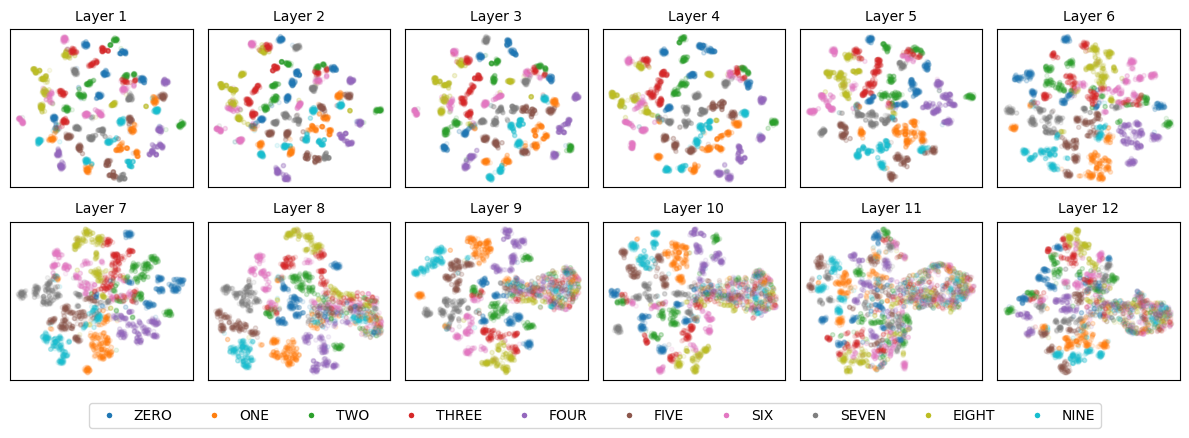

In [368]:
plot_tsne(tsne_layer_representations, labels, digit2word)

In [311]:
from sklearn.preprocessing import LabelEncoder

# Convert the categorical list into a list of integers
label_encoder = LabelEncoder()
speaker_ids_encoded = label_encoder.fit_transform(speaker_ids)

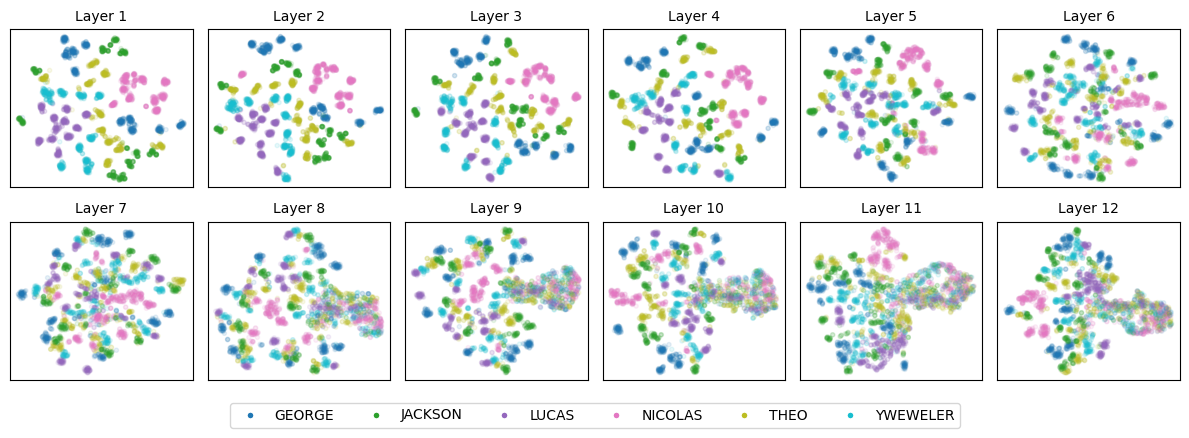

In [344]:
spkr2word = {i: spkr for (i, spkr) in enumerate(np.unique(speaker_ids))}

plot_tsne(tsne_layer_representations, speaker_ids_encoded, spkr2word)

In [313]:
model_ft = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

In [160]:
layer_reprs_ft = defaultdict()

for i, sample_ID in enumerate(resampled_samples):
    
    # Tokenize and forward pass through the model
    processed_sample = processor(
        resampled_samples[sample_ID].squeeze().numpy(), 
        return_tensors="pt", 
        sampling_rate=16000
    ).input_values

    with torch.no_grad():
        layer_reprs_ft[sample_ID] = model_ft(processed_sample, output_hidden_states=True).hidden_states


    print(f"{(100*i)/len(resampled_samples):.2f}%", end='\r')

In [362]:
# Iterate over the layers and plot the representations

tsne_layer_representations_ft = []

for layer_index in range(1, 13):
    # Extract representations from the specified layer
    layer_representations = []
    #speaker_ids, labels = [], []
    
    for sample_ID in layer_reprs_ft:
        layer_representations.append(layer_reprs_ft[sample_ID][layer_index].mean(dim=1).squeeze().numpy())

    # Convert the representations to a NumPy array
    layer_representations = np.array(layer_representations)

    # Perform T-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    tsne_representation = tsne.fit_transform(layer_representations)

    tsne_layer_representations_ft.append(tsne_representation)

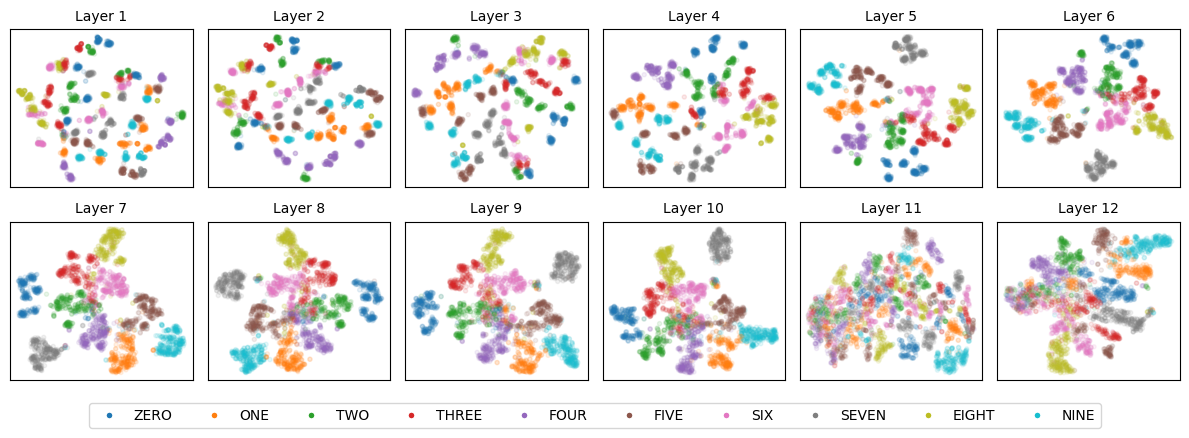

In [363]:
plot_tsne(tsne_layer_representations_ft, labels, digit2word)

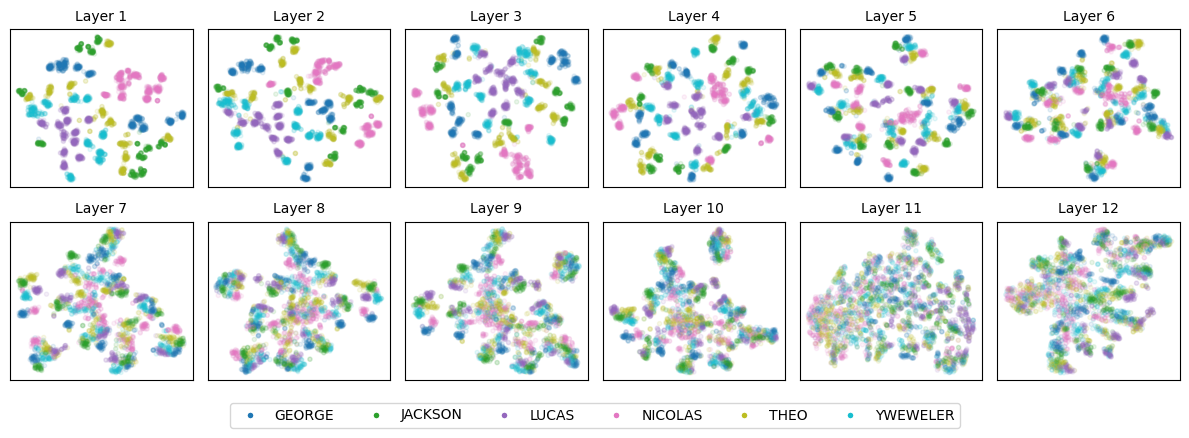

In [364]:
plot_tsne(tsne_layer_representations_ft, speaker_ids_encoded, spkr2word)

In [348]:
model_pt_large = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large and are newly initialized: ['lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [349]:
layer_reprs_pt_large = get_layer_representations(resampled_samples, model_pt_large)

In [365]:
tsne_layer_representations_pt_large = calculate_tsne_layer_representations(layer_reprs_pt_large)

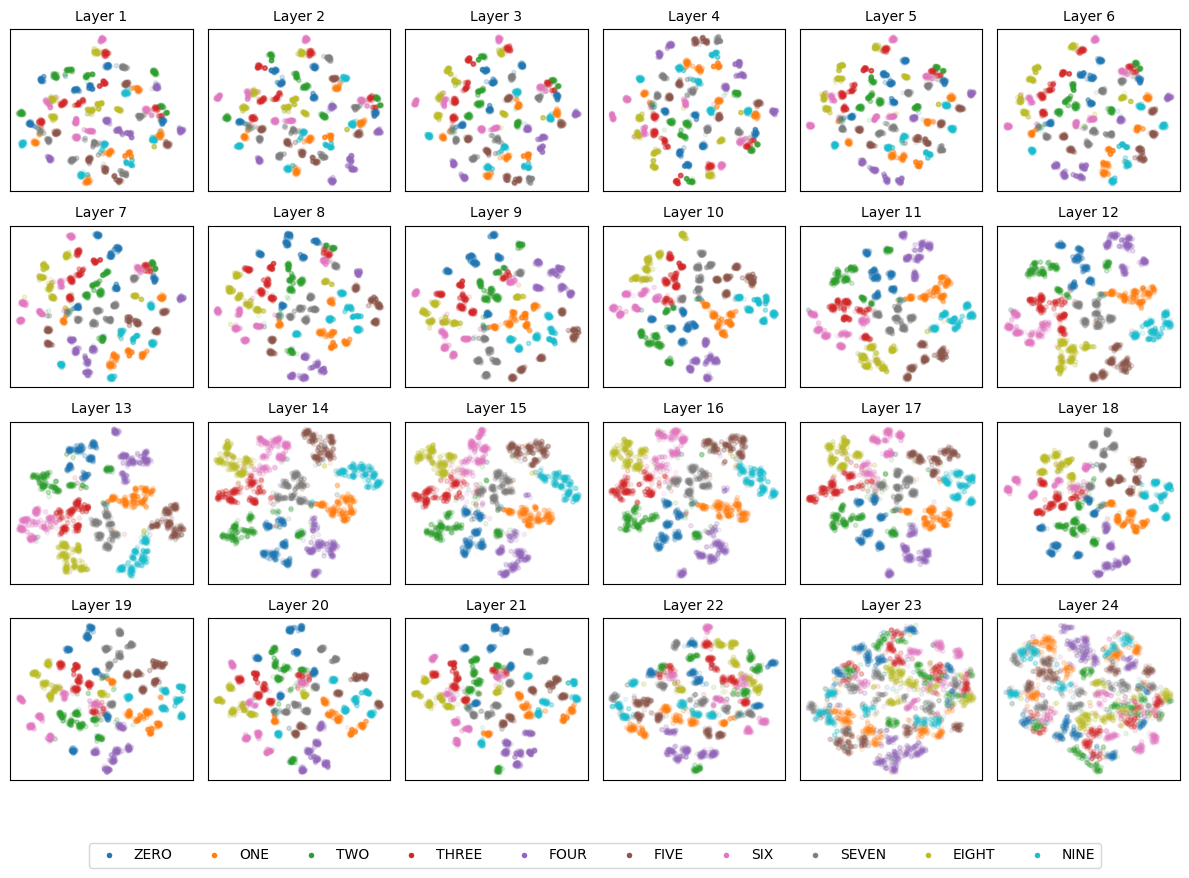

In [369]:
plot_tsne(tsne_layer_representations_pt_large, labels, digit2word)

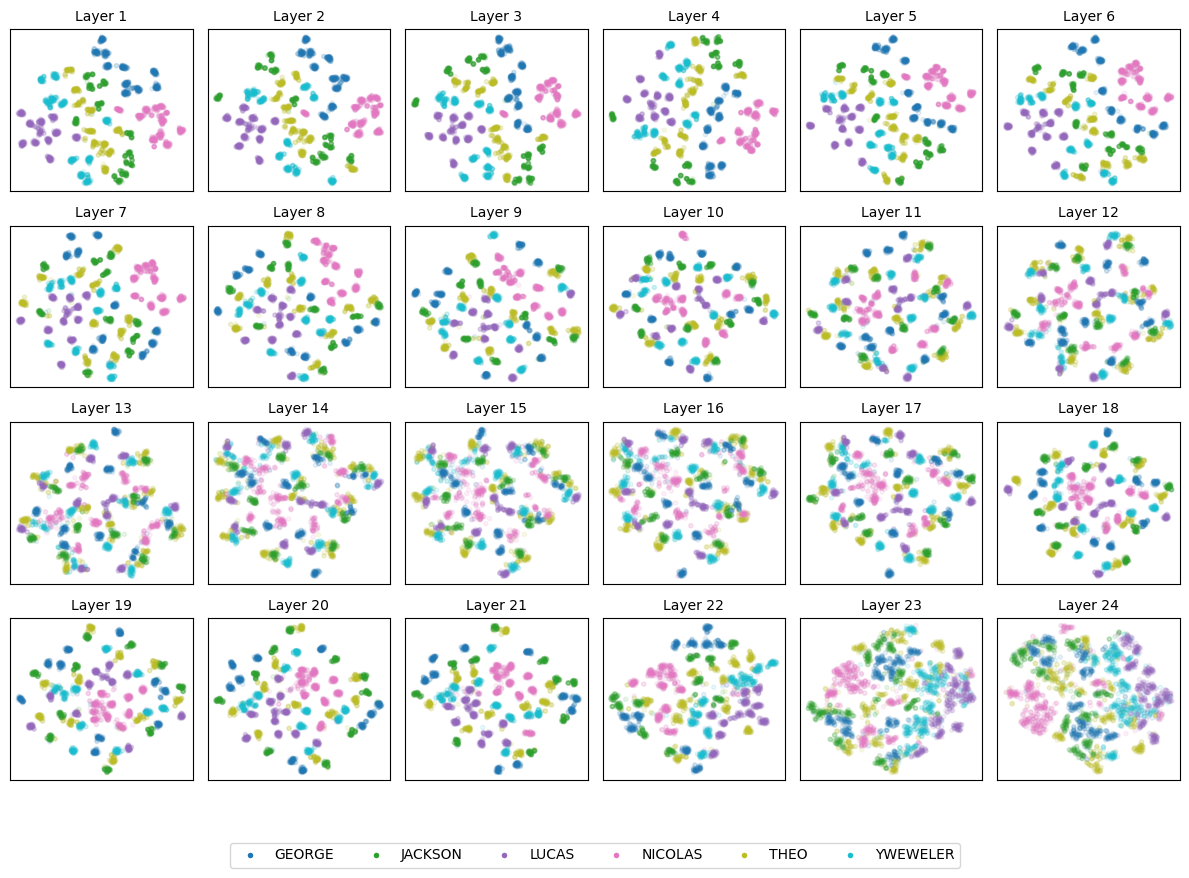

In [371]:
plot_tsne(tsne_layer_representations_pt_large, speaker_ids_encoded, spkr2word)

In [236]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score


for layer_idx in range(0, 13):
    # Get the representations from the current layer
    layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto', max_iter=5000)
    cluster_labels = kmeans.fit_predict(layer_representations)

    # Measure cluster purity
    purity = homogeneity_score(labels, cluster_labels)

    print(f'Layer {layer_idx+1} - Purity: {purity:.4f}')

Layer 1 - Purity: 0.3205
Layer 2 - Purity: 0.3286
Layer 3 - Purity: 0.3568
Layer 4 - Purity: 0.3456
Layer 5 - Purity: 0.4051
Layer 6 - Purity: 0.2958
Layer 7 - Purity: 0.4261
Layer 8 - Purity: 0.3882
Layer 9 - Purity: 0.3418
Layer 10 - Purity: 0.3086
Layer 11 - Purity: 0.2444
Layer 12 - Purity: 0.1230
Layer 13 - Purity: 0.1742


In [257]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

random_seeds = [42, 123, 8421, 1248, 333, 777, 666, 999, 111, 3232]

performance_metrics = defaultdict()

for layer_idx in range(0, 13):
    layer_performance = []
    
    for seed in random_seeds:
        np.random.seed(seed)
        cluster_labels_list = []

        # Get the representations from the current layer
        layer_representations = [layer_reprs_ft[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=10, random_state=seed, n_init='auto', max_iter=5000, init="k-means++")
        cluster_labels = kmeans.fit_predict(layer_representations)
        cluster_labels_list.append(cluster_labels)

        # Measure cluster purity
        purity = adjusted_rand_score(labels, cluster_labels)
        layer_performance.append(purity)
    
    performance_metrics[layer_idx] = layer_performance



for layer_idx in performance_metrics:

    performance_metrics_mean = np.mean(performance_metrics[layer_idx])
    performance_metrics_std = np.std(performance_metrics[layer_idx])

    print(f"Layer {layer_idx+1}:", end='\t')
    print(f"Mean: {performance_metrics_mean:.4f}", end='\t')
    print(f"Std.Dev: {performance_metrics_std:.4f}")


Layer 1:	Mean: 0.1946	Std.Dev: 0.0166
Layer 2:	Mean: 0.1825	Std.Dev: 0.0274
Layer 3:	Mean: 0.2288	Std.Dev: 0.0295
Layer 4:	Mean: 0.2803	Std.Dev: 0.0528
Layer 5:	Mean: 0.4234	Std.Dev: 0.0297
Layer 6:	Mean: 0.6520	Std.Dev: 0.0701
Layer 7:	Mean: 0.6533	Std.Dev: 0.0543
Layer 8:	Mean: 0.5091	Std.Dev: 0.0189
Layer 9:	Mean: 0.4258	Std.Dev: 0.0215
Layer 10:	Mean: 0.3698	Std.Dev: 0.0313
Layer 11:	Mean: 0.3398	Std.Dev: 0.0251
Layer 12:	Mean: 0.0276	Std.Dev: 0.0029
Layer 13:	Mean: 0.2596	Std.Dev: 0.0170


In [254]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

random_seeds = [42, 123, 8421, 1248, 333, 777, 666, 999, 111, 3232]

performance_metrics_ft = defaultdict()

for layer_idx in range(0, 13):
    layer_performance = []
    
    for seed in random_seeds:
        np.random.seed(seed)
        cluster_labels_list = []

        # Get the representations from the current layer
        layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=10, random_state=seed, n_init='auto', max_iter=5000, init="k-means++")
        cluster_labels = kmeans.fit_predict(layer_representations)
        cluster_labels_list.append(cluster_labels)

        # Measure cluster purity
        purity = adjusted_rand_score(labels, cluster_labels)
        layer_performance.append(purity)
    
    performance_metrics_ft[layer_idx] = layer_performance



for layer_idx in performance_metrics_ft:

    performance_metrics_mean = np.mean(performance_metrics_ft[layer_idx])
    performance_metrics_std = np.std(performance_metrics_ft[layer_idx])

    print(f"Layer {layer_idx+1}:", end='\t')
    print(f"Mean: {performance_metrics_mean:.4f}", end='\t')
    print(f"Std.Dev: {performance_metrics_std:.4f}")


Layer 1:	Mean: 0.1755	Std.Dev: 0.0114
Layer 2:	Mean: 0.1730	Std.Dev: 0.0159
Layer 3:	Mean: 0.2000	Std.Dev: 0.0220
Layer 4:	Mean: 0.2007	Std.Dev: 0.0183
Layer 5:	Mean: 0.2281	Std.Dev: 0.0152
Layer 6:	Mean: 0.2251	Std.Dev: 0.0372
Layer 7:	Mean: 0.2259	Std.Dev: 0.0219
Layer 8:	Mean: 0.2062	Std.Dev: 0.0206
Layer 9:	Mean: 0.2012	Std.Dev: 0.0234
Layer 10:	Mean: 0.1827	Std.Dev: 0.0202
Layer 11:	Mean: 0.1209	Std.Dev: 0.0138
Layer 12:	Mean: 0.0595	Std.Dev: 0.0069
Layer 13:	Mean: 0.0760	Std.Dev: 0.0100


In [293]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

random_seeds = [42, 123, 8421, 1248, 333, 777, 666, 999, 111, 3232]

performance_metrics_ft = defaultdict()

for layer_idx in range(0, 13):
    layer_performance = []
    
    for seed in random_seeds:
        np.random.seed(seed)
        cluster_labels_list = []

        # Get the representations from the current layer
        layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

        # Perform k-means clustering
        kmeans = KMeans(n_clusters=10, random_state=seed, n_init='auto', max_iter=500, init="random")
        cluster_labels = kmeans.fit_predict(layer_representations)
        cluster_labels_list.append(cluster_labels)

        # Measure cluster purity
        purity = adjusted_rand_score(labels, cluster_labels)
        layer_performance.append(purity)
    
    performance_metrics_ft[layer_idx] = layer_performance

    performance_metrics_mean = np.mean(layer_performance)
    performance_metrics_std = np.std(layer_performance)

    print(f"Layer {layer_idx+1}:", end='\t')
    print(f"Mean: {performance_metrics_mean:.4f}", end='\t')
    print(f"Std.Dev: {performance_metrics_std:.4f}")


Layer 1:	Mean: 0.1784	Std.Dev: 0.0176
Layer 2:	Mean: 0.1772	Std.Dev: 0.0074
Layer 3:	Mean: 0.1925	Std.Dev: 0.0145
Layer 4:	Mean: 0.2066	Std.Dev: 0.0110
Layer 5:	Mean: 0.2143	Std.Dev: 0.0179
Layer 6:	Mean: 0.2322	Std.Dev: 0.0257
Layer 7:	Mean: 0.2245	Std.Dev: 0.0280
Layer 8:	Mean: 0.2189	Std.Dev: 0.0143
Layer 9:	Mean: 0.1976	Std.Dev: 0.0070
Layer 10:	Mean: 0.1656	Std.Dev: 0.0109
Layer 11:	Mean: 0.1130	Std.Dev: 0.0152
Layer 12:	Mean: 0.0647	Std.Dev: 0.0060
Layer 13:	Mean: 0.0674	Std.Dev: 0.0003


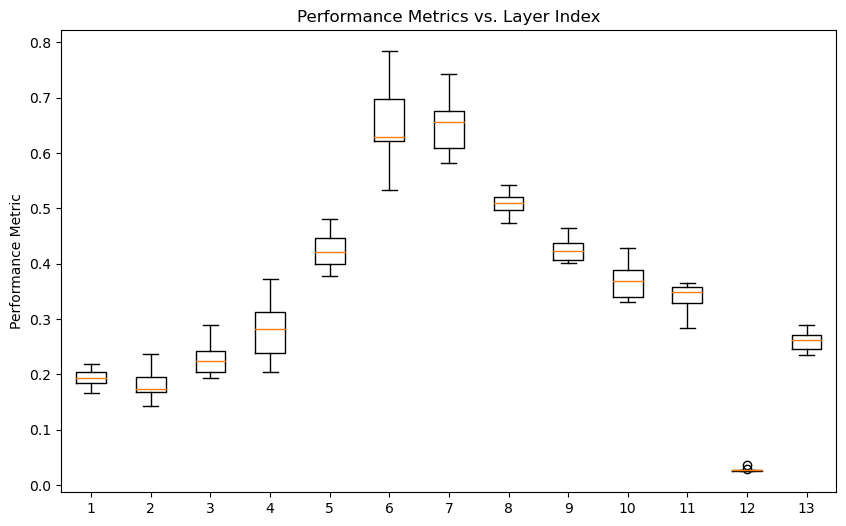

In [261]:
# Extract the performance metrics from the dictionary
performance_metrics_values = list(performance_metrics.values())

# Create a list of layer indices
layer_indices = list(range(1, 14))

# Create a list of labels for the x-axis
x_labels = [f'{i}' for i in layer_indices]

# Create a list of performance metric values
y_values = performance_metrics_values

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the boxplot
ax.boxplot(y_values)

# Set the x-axis labels
ax.set_xticklabels(x_labels)

# Set the y-axis label
ax.set_ylabel('Performance Metric')

# Set the title
ax.set_title('Performance Metrics vs. Layer Index')

# Show the plot
plt.show()


In [325]:
len(performance_metrics_values)

13

In [324]:
np.mean(performance_metrics_values, axis=0)

array([0.35790273, 0.32573158, 0.35397332, 0.36896334, 0.3337529 ,
       0.360084  , 0.34330552, 0.34988592, 0.35443348, 0.34942029])

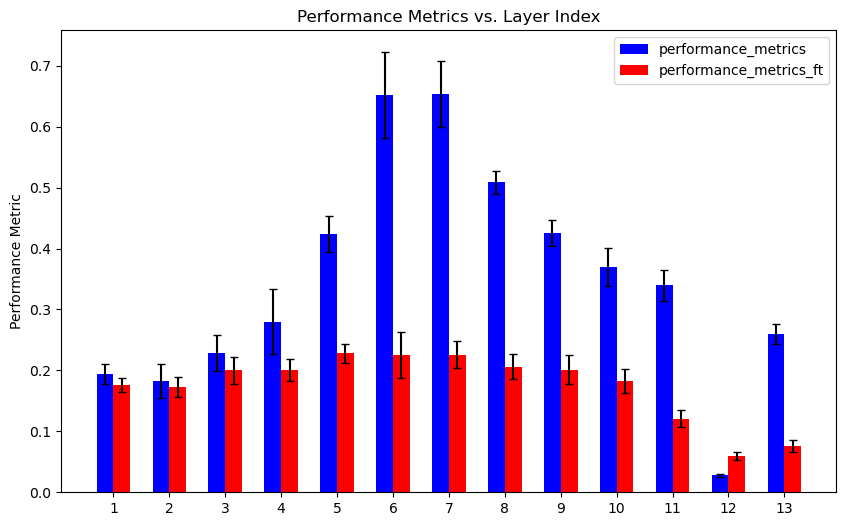

In [337]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the mean and standard error for performance_metrics
mean_performance_metrics = np.mean(performance_metrics_values, axis=1)
std_performance_metrics = np.std(performance_metrics_values, axis=1)
std_error_performance_metrics = std_performance_metrics #/ np.sqrt(len(performance_metrics_values))

# Calculate the mean and standard error for performance_metrics_ft
mean_performance_metrics_ft = np.mean(performance_metrics_values_ft, axis=1)
std_performance_metrics_ft = np.std(performance_metrics_values_ft, axis=1)
std_error_performance_metrics_ft = std_performance_metrics_ft #/ np.sqrt(len(performance_metrics_values_ft))

# Set the width of the bars
bar_width = 0.3

# Create the bar chart for performance_metrics with blue color
ax.bar(np.array(range(1, 14))-0.15, mean_performance_metrics, width=bar_width, yerr=std_error_performance_metrics, color='blue', label='performance_metrics', capsize=3)

# Create the bar chart for performance_metrics_ft with green color
ax.bar(np.array(range(1, 14))+0.15, mean_performance_metrics_ft, width=bar_width, yerr=std_error_performance_metrics_ft, color='red', label='performance_metrics_ft', capsize=3)

# Set the x-axis labels
ax.set_xticks(range(1, 14))
ax.set_xticklabels([str(i) for i in range(1, 14)])

# Set the y-axis label
ax.set_ylabel('Performance Metric')

# Set the title
ax.set_title('Performance Metrics vs. Layer Index')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [334]:
# Calculate the mean values for performance_metrics and performance_metrics_ft
performance_metrics_mean = np.mean(performance_metrics_values, axis=1)
performance_metrics_ft_mean = np.mean(performance_metrics_values_ft, axis=1)
performance_metrics_std = np.std(performance_metrics_values, axis=1)
performance_metrics_ft_std = np.std(performance_metrics_values_ft, axis=1)

# Plot the mean values as a line chart
ax.plot(range(1, 14), performance_metrics_mean, marker='o', color='blue', label='performance_metrics')
ax.plot(range(1, 14), performance_metrics_ft_mean, marker='o', color='green', label='performance_metrics_ft')

# Plot the standard deviation as error bars
ax.errorbar(range(1, 14), performance_metrics_mean, yerr=performance_metrics_std, fmt='o', color='blue', label='performance_metrics_std')
ax.errorbar(range(1, 14), performance_metrics_ft_mean, yerr=performance_metrics_ft_std, fmt='o', color='green', label='performance_metrics_ft_std')

# Set the x-axis labels
ax.set_xticks(range(1, 14))
ax.set_xticklabels([str(i) for i in range(1, 14)])

# Set the y-axis label
ax.set_ylabel('Performance Metric')

# Set the title
ax.set_title('Performance Metrics vs. Layer Index')

# Add a legend
ax.legend()

# Show the plot
plt.show()


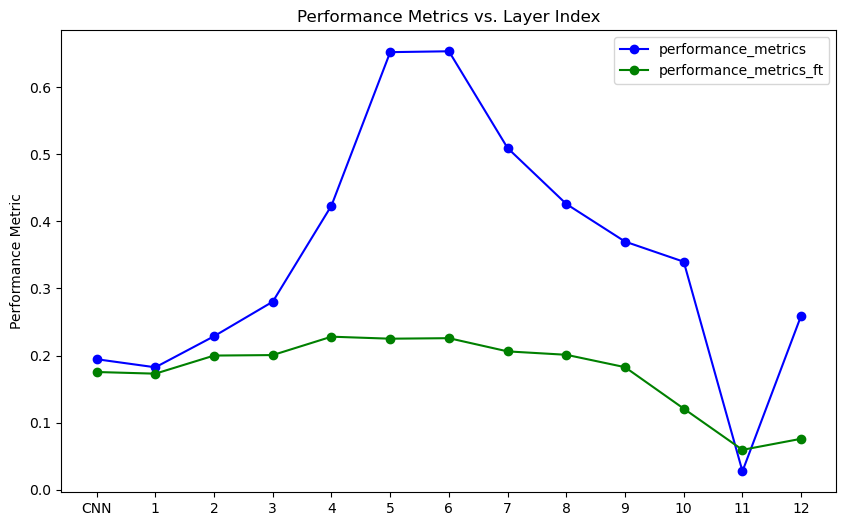

In [320]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the mean values for performance_metrics and performance_metrics_ft
performance_metrics_mean = np.mean(performance_metrics_values, axis=1)
performance_metrics_ft_mean = np.mean(performance_metrics_values_ft, axis=1)

# Plot the mean values as a line chart
ax.plot(range(0, 13), performance_metrics_mean, marker='o', color='blue', label='performance_metrics')
ax.plot(range(0, 13), performance_metrics_ft_mean, marker='o', color='green', label='performance_metrics_ft')

# Set the x-axis labels
ax.set_xticks(range(0, 13))
ax.set_xticklabels(['CNN'] + [str(i) for i in range(1, 13)])

# Set the y-axis label
ax.set_ylabel('Performance Metric')

# Set the title
ax.set_title('Performance Metrics vs. Layer Index')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [381]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, ] # estimator[-1].inertia_

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))


In [385]:
print("\t\tinit\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print(92* "_")

# Get the representations from the current layer
for layer_idx in range(0, 13):
    layer_representations = [layer_reprs_ft[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx+1:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=10, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=labels)



		init		time	homo	compl	v-meas	ARI	AMI	silhouette
____________________________________________________________________________________________
Layer 1  	k-means++	0.149s	0.317	0.329	0.323	0.156	0.319	0.114
Layer 2  	k-means++	0.086s	0.321	0.332	0.326	0.165	0.322	0.093
Layer 3  	k-means++	0.086s	0.314	0.320	0.317	0.177	0.313	0.089
Layer 4  	k-means++	0.095s	0.406	0.414	0.410	0.246	0.407	0.087
Layer 5  	k-means++	0.109s	0.588	0.593	0.591	0.444	0.588	0.099
Layer 6  	k-means++	0.130s	0.780	0.790	0.785	0.698	0.784	0.116
Layer 7  	k-means++	0.114s	0.713	0.736	0.724	0.561	0.723	0.108
Layer 8  	k-means++	0.104s	0.568	0.639	0.601	0.339	0.599	0.062
Layer 9  	k-means++	0.170s	0.558	0.593	0.575	0.354	0.573	0.127
Layer 10 	k-means++	0.119s	0.524	0.561	0.542	0.328	0.539	0.107
Layer 11 	k-means++	0.125s	0.429	0.457	0.442	0.260	0.439	0.112
Layer 12 	k-means++	0.096s	0.253	0.267	0.260	0.129	0.255	0.124
Layer 13 	k-means++	0.095s	0.429	0.444	0.437	0.286	0.433	0.111


In [386]:
print("\t\tinit\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print(92* "_")

# Get the representations from the current layer
for layer_idx in range(0, 25):
    layer_representations = [layer_reprs_pt_large[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=10, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=labels)

		init		time	homo	compl	v-meas	ARI	AMI	silhouette
____________________________________________________________________________________________
Layer 0  	k-means++	0.159s	0.390	0.400	0.395	0.215	0.391	0.127
Layer 1  	k-means++	0.142s	0.262	0.267	0.265	0.118	0.260	0.126
Layer 2  	k-means++	0.171s	0.269	0.272	0.271	0.115	0.266	0.132
Layer 3  	k-means++	0.157s	0.189	0.198	0.193	0.071	0.189	0.123
Layer 4  	k-means++	0.141s	0.235	0.246	0.240	0.097	0.235	0.092
Layer 5  	k-means++	0.155s	0.335	0.344	0.340	0.176	0.336	0.091
Layer 6  	k-means++	0.190s	0.313	0.321	0.317	0.159	0.313	0.096
Layer 7  	k-means++	0.118s	0.417	0.450	0.433	0.238	0.429	0.086
Layer 8  	k-means++	0.131s	0.601	0.623	0.612	0.445	0.609	0.079
Layer 9  	k-means++	0.142s	0.631	0.663	0.647	0.488	0.645	0.085
Layer 10 	k-means++	0.108s	0.652	0.733	0.690	0.483	0.688	0.081
Layer 11 	k-means++	0.115s	0.659	0.720	0.688	0.516	0.686	0.106
Layer 12 	k-means++	0.133s	0.724	0.760	0.742	0.579	0.740	0.094
Layer 13 	k-means++	0.179s	0.725	0.751

In [ ]:
import pickle

# Specify the file path to save the pickle object
file_path = 'layer_reprs_large_pt.pkl'

# Save the layer_reprs_pt_large as a pickle object
with open(file_path, 'wb') as file:
    pickle.dump(layer_reprs_pt_large, file)


# Specify the file paths to save the pickle objects
file_path_ft = 'layer_reprs_base_ft.pkl'
file_path_pt = 'layer_reprs_base_pt.pkl'

# Save the layer_reprs_ft as a pickle object
with open(file_path_ft, 'wb') as file:
    pickle.dump(layer_reprs_ft, file)

# Save the layer_reprs as a pickle object
with open(file_path, 'wb') as file:
    pickle.dump(layer_reprs_pt, file)


In [387]:
print("\t\tinit\t\ttime\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
print(92* "_")

# Get the representations from the current layer
for layer_idx in range(0, 25):
    layer_representations = [layer_reprs_pt_large[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=6, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=speaker_ids_encoded)



		init		time	homo	compl	v-meas	ARI	AMI	silhouette
____________________________________________________________________________________________
Layer 0  	k-means++	0.123s	0.375	0.385	0.380	0.314	0.379	0.133
Layer 1  	k-means++	0.133s	0.640	0.656	0.648	0.562	0.647	0.104
Layer 2  	k-means++	0.173s	0.525	0.562	0.543	0.410	0.542	0.101
Layer 3  	k-means++	0.142s	0.660	0.678	0.669	0.564	0.668	0.093
Layer 4  	k-means++	0.118s	0.579	0.680	0.625	0.453	0.625	0.096
Layer 5  	k-means++	0.161s	0.563	0.594	0.578	0.444	0.577	0.084
Layer 6  	k-means++	0.162s	0.679	0.695	0.687	0.600	0.686	0.082
Layer 7  	k-means++	0.136s	0.339	0.371	0.355	0.220	0.353	0.093
Layer 8  	k-means++	0.172s	0.236	0.270	0.252	0.162	0.250	0.095
Layer 9  	k-means++	0.263s	0.170	0.177	0.173	0.124	0.171	0.076
Layer 10 	k-means++	0.148s	0.163	0.169	0.166	0.104	0.164	0.073
Layer 11 	k-means++	0.109s	0.116	0.123	0.119	0.066	0.117	0.076
Layer 12 	k-means++	0.121s	0.087	0.097	0.092	0.050	0.089	0.091
Layer 13 	k-means++	0.199s	0.018	0.019

In [289]:
   print("\t\tinit\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
   print(120* "_")

# Get the representations from the current layer
for layer_idx in range(0, 13):
    layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx+1:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=10, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=labels)

		init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________________________________________________________
Layer 1  	k-means++	0.158s	1461034	0.330	0.340	0.335	0.166	0.331	0.126
Layer 2  	k-means++	0.097s	1550286	0.270	0.276	0.273	0.128	0.269	0.115
Layer 3  	k-means++	0.117s	1656880	0.288	0.303	0.295	0.132	0.291	0.097
Layer 4  	k-means++	0.135s	1730121	0.354	0.368	0.361	0.190	0.357	0.078
Layer 5  	k-means++	0.112s	1761366	0.357	0.369	0.363	0.233	0.359	0.080
Layer 6  	k-means++	0.101s	1749440	0.403	0.417	0.410	0.254	0.407	0.076
Layer 7  	k-means++	0.119s	1781167	0.368	0.411	0.388	0.180	0.384	0.113
Layer 8  	k-means++	0.123s	1705898	0.385	0.419	0.401	0.191	0.397	0.184
Layer 9  	k-means++	0.140s	1683813	0.424	0.451	0.437	0.241	0.433	0.101
Layer 10 	k-means++	0.094s	1447084	0.374	0.387	0.380	0.263	0.376	0.087
Layer 11 	k-means++	0.111s	1396049	0.164	0.177	0.170	0.073	0.165	0.095
Layer 12 	k-means++	0.159s	1178301	0.151

In [295]:
   print("\t\tinit\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
   print(120* "_")

# Get the representations from the current layer
for layer_idx in range(0, 13):
    layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=6, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=speaker_ids_encoded)



		init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________________________________________________________
Layer 0  	k-means++	0.086s	1647946	0.476	0.488	0.482	0.397	0.481	0.127
Layer 1  	k-means++	0.076s	1733416	0.438	0.470	0.453	0.335	0.452	0.115
Layer 2  	k-means++	0.117s	1808156	0.461	0.485	0.473	0.367	0.471	0.096
Layer 3  	k-means++	0.112s	1868534	0.344	0.357	0.351	0.254	0.349	0.082
Layer 4  	k-means++	0.099s	1889534	0.223	0.228	0.225	0.175	0.224	0.082
Layer 5  	k-means++	0.103s	1872231	0.167	0.170	0.168	0.126	0.166	0.066
Layer 6  	k-means++	0.080s	1904019	0.179	0.185	0.182	0.116	0.180	0.117
Layer 7  	k-means++	0.126s	1843665	0.069	0.074	0.071	0.048	0.069	0.150
Layer 8  	k-means++	0.101s	1844488	0.102	0.104	0.103	0.067	0.101	0.086
Layer 9  	k-means++	0.098s	1622054	0.097	0.108	0.102	0.053	0.100	0.121
Layer 10 	k-means++	0.105s	1515476	0.099	0.114	0.106	0.066	0.104	0.112
Layer 11 	k-means++	0.127s	1333349	0.100

In [296]:
   print("\t\tinit\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
   print(120* "_")

# Get the representations from the current layer
for layer_idx in range(0, 13):
    layer_representations = [layer_reprs_ft[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx:<3}", end='\t')

    kmeans = KMeans(init="k-means++", n_clusters=6, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="k-means++", data=layer_representations, labels=speaker_ids_encoded)



		init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________________________________________________________
Layer 0  	k-means++	0.096s	1698850	0.502	0.522	0.512	0.444	0.511	0.132
Layer 1  	k-means++	0.119s	1765145	0.437	0.453	0.444	0.352	0.443	0.109
Layer 2  	k-means++	0.084s	1837814	0.317	0.327	0.322	0.226	0.320	0.088
Layer 3  	k-means++	0.121s	1865197	0.287	0.292	0.289	0.238	0.288	0.079
Layer 4  	k-means++	0.084s	1860593	0.115	0.117	0.116	0.090	0.114	0.097
Layer 5  	k-means++	0.075s	1879840	0.046	0.047	0.047	0.032	0.044	0.108
Layer 6  	k-means++	0.099s	1876757	0.089	0.091	0.090	0.070	0.088	0.092
Layer 7  	k-means++	0.090s	1839646	0.044	0.049	0.047	0.033	0.044	0.076
Layer 8  	k-means++	0.100s	1865108	0.054	0.060	0.057	0.042	0.055	0.089
Layer 9  	k-means++	0.149s	1861693	0.048	0.051	0.050	0.036	0.047	0.067
Layer 10 	k-means++	0.087s	1759740	0.086	0.099	0.092	0.062	0.090	0.121
Layer 11 	k-means++	0.097s	1345501	0.061

In [290]:
   print("\t\tinit\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
   print(120* "_")

# Get the representations from the current layer
for layer_idx in range(0, 13):
    layer_representations = [layer_reprs[sample_ID][layer_idx].mean(dim=1).squeeze().numpy() for sample_ID in layer_reprs]

    
    print(f"Layer {layer_idx+1:<3}", end='\t')

    kmeans = KMeans(init="random", n_clusters=10, n_init='auto', random_state=42)
    bench_k_means(kmeans=kmeans, name="random", data=layer_representations, labels=labels)



		init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
________________________________________________________________________________________________________________________
Layer 1  	random   	0.534s	1448527	0.325	0.330	0.328	0.165	0.324	0.140
Layer 2  	random   	0.704s	1523740	0.299	0.309	0.304	0.142	0.300	0.118
Layer 3  	random   	0.703s	1643022	0.311	0.322	0.316	0.143	0.312	0.098
Layer 4  	random   	0.757s	1713466	0.305	0.312	0.309	0.156	0.304	0.093
Layer 5  	random   	0.833s	1746998	0.371	0.386	0.379	0.226	0.375	0.085
Layer 6  	random   	0.740s	1732209	0.380	0.402	0.391	0.245	0.387	0.073
Layer 7  	random   	0.734s	1758376	0.455	0.488	0.471	0.276	0.467	0.147
Layer 8  	random   	0.652s	1700682	0.449	0.493	0.470	0.229	0.467	0.184
Layer 9  	random   	0.732s	1677111	0.413	0.429	0.421	0.241	0.417	0.103
Layer 10 	random   	0.688s	1444829	0.314	0.336	0.324	0.209	0.320	0.123
Layer 11 	random   	0.538s	1374729	0.139	0.147	0.143	0.066	0.137	0.093
Layer 12 	random   	1.038s	1174075	0.166

/tmp/ipykernel_7124/2229883987.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


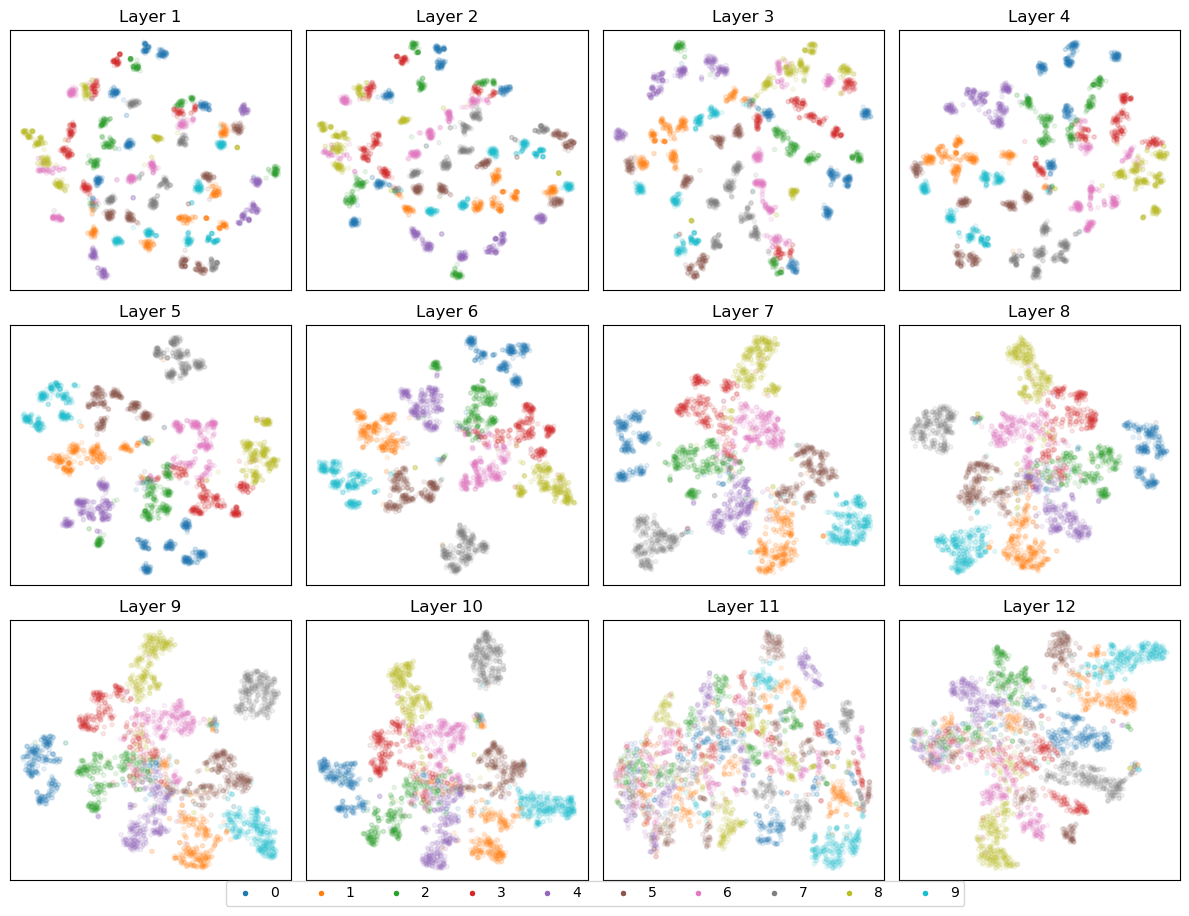

In [185]:

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the layers and plot t-sne representations
for i, tsne_representation in enumerate(tsne_layer_representations_ft):

    # Plot the representations in the current subplot
    scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels, cmap='tab10', alpha=0.1, marker='.')
    axes[i].set_title(f'Layer {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove any extra subplots
for j in range(len(axes)):
    if j >= len(layer_reprs):
        fig.delaxes(axes[j])


# Adjust the spacing between subplots
fig.tight_layout()

# Add legend with color labels at the bottom
legend_labels = np.unique(labels)
legend_handles = [
    plt.Line2D(
        [0], 
        [0], 
        marker='.', 
        color='w', 
        markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in legend_labels
    ]

fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.02))

fig.tight_layout()

plt.show()

/tmp/ipykernel_7124/708935113.py:39: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


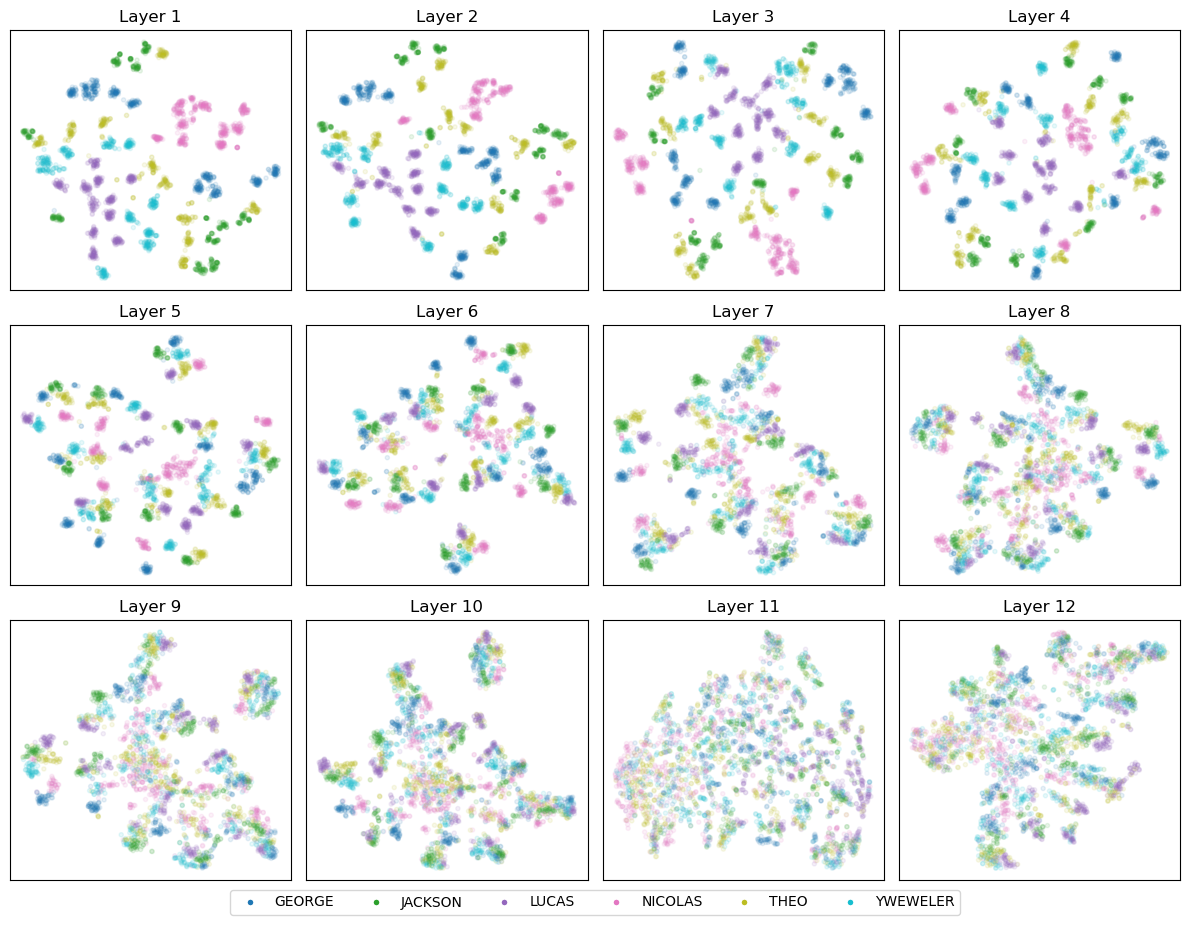

In [195]:

# Create a new figure and set the size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the layers and plot t-sne representations
for i, tsne_representation in enumerate(tsne_layer_representations_ft):

    # Plot the representations in the current subplot
    scatter = axes[i].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=speaker_ids_encoded, cmap='tab10', alpha=0.1, marker='.')
    axes[i].set_title(f'Layer {i+1}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Remove any extra subplots
for j in range(len(axes)):
    if j >= len(layer_reprs):
        fig.delaxes(axes[j])



# Adjust the spacing between subplots
fig.tight_layout()

# Add legend with color labels at the bottom
legend_labels = [spkr.upper() for spkr in np.unique(speaker_ids)]
legend_handles = [
    plt.Line2D(
        [0], 
        [0], 
        marker='.', 
        color='w', 
        markerfacecolor=scatter.get_cmap()(scatter.norm(label)), markersize=10) for label in set(speaker_ids_encoded)
]

fig.legend(legend_handles, legend_labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.03))

fig.tight_layout()



plt.show()